# import libraries

In [108]:
#--- system libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import pdb
import sys
#
matplotlib.rcParams['text.usetex'] = True
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
reload(lp)

<module 'LammpsPostProcess' from 'LammpsPostProcess.pyc'>

# utility functions

In [161]:
def to_dict( df ):
    sdict = {}
    skeys = df.keys().to_list()
    for ikey in skeys:
        sdict[ikey] = df[ikey].to_list()

    return sdict

def isSane( AddColumns, columnList ):
    #--- avoid duplicates
    assert len( set( AddColumns ) ) == len( AddColumns ), 'duplicates in the list!'
    #--- assert column list is not already included
    n = len( AddColumns )
    AddColumns = list( set(AddColumns) - set( columnList ) )
    if len(AddColumns) != n:
        print 'column already included!'
        return False
    return True

        
def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()

# input stress file

In [4]:
path = '/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/BmgData'
fileNamee = ('FeNi.txt', 
             'CoNiCr.txt', 
             'CoNiCrFe.txt',
             'CoCrFeMn.txt',
             'Co5Cr2Fe40Mn27Ni26.txt')[0]

stress = np.loadtxt('%s/%s'%(path,fileNamee) )

# stress-strain curve

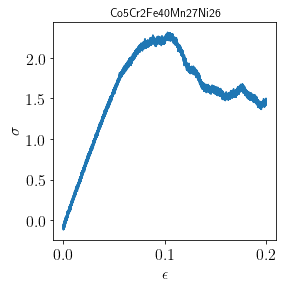

In [395]:
def DrawFrame(ax, (alpha_xl,alpha_xr),(alpha_yb,alpha_yt),linewidth,LOG_X=None,LOG_Y=None):
    [xlo,xhi,ylo,yhi] = ax.axis()
    if LOG_X:
        [xlo,xhi,junk,junk] = np.log10(ax.axis())
    if LOG_Y:
        [junk,junk,ylo,yhi] = np.log10(ax.axis())
    lx = xhi - xlo
    ly = yhi - ylo
    xy = [xlo - alpha_xl * lx, ylo - alpha_yb * ly]
    height = ly*(1+alpha_yb+alpha_yt)
    width = lx*(1+alpha_xl+alpha_xr)
    xy_end=[xy[0]+width,xy[1]+height]
    if LOG_X:
        xy[0] = 10 ** xy[0]
        xy_end[0] = 10 ** xy_end[0]
    if LOG_Y:
        xy[1] = 10 ** xy[1]
        xy_end[1] = 10 ** xy_end[1]
    ax.add_patch( patches.Rectangle(xy=xy, width=xy_end[0]-xy[0], 
                                    height=xy_end[1]-xy[1], linewidth=linewidth,
                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
    
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\sigma$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title(fileNamee[:-4])
#
ax.plot(stress[:,0],stress[:,1],'-')

#--- point corresponding to strain maps
ADD_POINTS = False
strain = []
Virial = []
if ADD_POINTS:
    for itime in coord_atoms_broken:
        CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] )
        volume = np.linalg.det( CellVectorOrtho )
        virial = np.c_[coord_atoms_broken[itime]['c_mystress4']].astype(float).sum() / volume
        #--- strain
        dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
        l1=CellVector[ itime ][1,1]
        strain += [0.5*dx/l1]
        Virial += [virial*1e-4] 
    #
    ax.plot(2*np.array(strain), Virial, 'x',color='red')
#
plt.savefig(fileNamee[:-4]+'.png',dpi=75,bbox_inches='tight')
plt.show()
#
np.savetxt('4.txt',np.c_[2*np.array(strain), Virial])

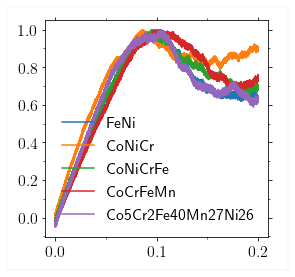

In [4]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
# ax.set_xlabel(r'$\epsilon$',fontsize=20)
# ax.set_ylabel(r'$\sigma/\sigma_y$',fontsize=20)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(labelsize=16,which='both',axis='both', top=True, right=True)
#ax.set_title(fileNamee[:-4])
#
FileNamee = ('FeNi.txt', 
             'CoNiCr.txt', 
             'CoNiCrFe.txt',
             'CoCrFeMn.txt',
             'Co5Cr2Fe40Mn27Ni26.txt')
#FileNamee = ['CoNiCrFe.txt']
#
for fileNamee in FileNamee:
    stress = np.loadtxt('%s/%s'%(path,fileNamee) )
    #
    ax.plot(stress[:,0],stress[:,1]/stress[:,1].max(),'-', label = fileNamee[:-4])
ax.legend(frameon=False, fontsize=16)
#
DrawFrame(ax, (0.17,0.09),(0.15,0.06),0.04)
#
plt.savefig('loadCurve.png',dpi=2*75,bbox_inches='tight')
plt.show()

# Plastic Deformation
## Dump File

In [115]:
# def GetCordsTimeStep(slist):
#     slist.readline()
#     itime = int( slist.readline().split()[0] )
    
#     [slist.readline() for i in xrange(1)]
#     nrows = int(slist.readline().split()[0])

#     [slist.readline() for i in xrange(1)]
    
#     CellVector = np.array([slist.readline().split() for i in xrange( 3 )])
    
#     cols = slist.readline().split()[2:]
    
#     return np.array([slist.readline().split() for i in xrange( nrows )]), CellVector, itime, cols
    
# def GetCords( file_name ):
#     slist = open( file_name )    
#     coord_atoms_broken = {}
#     CellVector = {}
#     try:
#         while True:
#             sarr, cell_vector, itime, cols  = GetCordsTimeStep( slist ) #--- get coord
#             #--- insert in a data frame
#             coord_atoms_broken[ itime ] = pd.DataFrame( sarr, columns = cols )
            
#             #--- cast id to 'int'
#             coord_atoms_broken[ itime ]['id'] = map(int,coord_atoms_broken[ itime ]['id'].tolist())[:]

#             #--- sort
#             coord_atoms_broken[ itime ].sort_values( by = 'id', inplace = True )
            
#             #--- reset index
#             coord_atoms_broken[ itime ].reset_index( drop=True, inplace=True )
            
#             CellVector[ itime ] = cell_vector
#     except:
# #        traceback.print_exc()
#         pass

    
#     return coord_atoms_broken, CellVector

# def GetCellVector( CellVector ):
#     CellVector[0] = np.c_[CellVector[0],['0.0','0.0','0.0']] #--- ref. state

#     CellOrigin = {}
#     cell_vector = {}
    
#     for itime in CellVector:
#         row0 = map( float, CellVector[ itime ][ 0 ] )
#         l0 = row0[ 1 ] - row0[ 0 ] - row0[ 2 ]
#         CellVector0 = np.array( [ l0, 0.0, 0.0 ] )
#         dx = row0[ 2 ]
        
#         row1 =  map( float, CellVector[ itime ][ 1 ] )
#         l1 = row1[ 1 ] - row1[ 0 ]
#         a1 = np.array( [ 0.0, l1, 0.0 ] )
#         CellVector1 = CellVector0 * ( dx / l0 ) + a1
        
#         row2 =  map( float, CellVector[ itime ][ 2 ] )
#         l2 = row2[ 1 ] - row2[ 0 ]
#         CellVector2 = np.array( [ 0.0, 0.0, l2 ] )
        
#         CellOrigin[ itime ] = np.array( [ row0[ 0 ], row1[ 0 ], row2[ 0 ] ] )
#         cell_vector[ itime ] = np.c_[ CellVector0, CellVector1, CellVector2 ] 

#     return CellOrigin, cell_vector



fileName = '%s/%s'%(path,['FeNi_glass.dump',
            'CoNiCr_glass.dump',
            'CoNiCrFe_glass.dump',
            'CoCrFeMn_glass.dump',
            'Co5Cr2Fe40Mn27Ni26_glass.dump'][0])#--- parse cords

#path = '/Users/Home/Desktop/Tmp/txt' 
#fileName = '%s/virialStress.xyz'%path

#--- parse lammps data
lmpData = lp.ReadDumpFile( fileName )
lmpData.GetCords( ncount = sys.maxint )

#coord_atoms_broken, cell_vector = GetCords( fileName ) #--- add xyz for broken bonds #--- check id!!1
#CellOrigin, CellVector = GetCellVector( cell_vector )

hello from Atoms const
BoxBounds.shape=3,3 is not (3,3)!
add [0. 0. 0.]!


## Compute Displacements


In [394]:
# def ChangeBasis( coord_atoms_broken, CellVector, CellOrigin, **kwargs ):
# ############################################################
# ####### map atoms within a tilted box to an orthogonal one
# ############################################################

#     DimensionlessCords = GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin  ) #--- beta0, beta1, beta2

#     #--- shift (beta0 + beta1 * dx / |b0| > 1) by - b0
#     #--- [b0,b1]^{-1}*(x=|b0|,y)
    
#     b2 = CellVector[:,2]
#     b1 = CellVector[:,1]
#     b0 = CellVector[:,0]
#     norm_b0 = np.dot(b0,b0)**0.5
#     shift0 = np.dot(b1, b0 / norm_b0 )
#     #
#     indices_shiftTrue = (DimensionlessCords['beta0']) + (DimensionlessCords['beta1'])*shift0/norm_b0 >= 1.0
#     n = len( indices_shiftTrue )
#     shift_matrix =  np.array(indices_shiftTrue).reshape((n,1)) * b0
#     #
#     xyz = coord_atoms_broken - shift_matrix
#     #
#     attr_list = ['x','y','z']
#     values = xyz
#     for keys in kwargs:
#         attr_list += [ keys ]
#         values = np.c_[values,kwargs[keys]]
                
#     return pd.DataFrame( values, columns = attr_list )

# def AddCopies( coord_atoms_broken, CellVector, **kwargs ):    
#     #--- orignial cell
#     XYZ_shifted = coord_atoms_broken
#     xyz_original = XYZ_shifted.copy()
#     #---
#     attr_list = ['x','y','z']
#     values = XYZ_shifted
#     for keys in kwargs:
#         attr_list += [ keys ]
#         values = np.c_[values,kwargs[keys]]

#     ID_TYPE_shifted = values[:,3:]
#     id_type_original = ID_TYPE_shifted.copy()
    
#     #--- cell copies
#     for i in [-1,0,1]:
#         for j in [-1,0,1]:
#             for k in [-1,0,1]:
#     #            print i,j,k
#                 if i == j == k == 0:
#                     continue
#                 total_shift = np.matmul( CellVector, np.array([i,j,k]) )
#                 #--- add shift
#                 xyz_shifted = xyz_original + total_shift
#                 #--- append
#                 XYZ_shifted = np.concatenate( ( XYZ_shifted, xyz_shifted ), axis = 0 )
#                 ID_TYPE_shifted = np.concatenate( ( ID_TYPE_shifted, id_type_original ), axis = 0 )
                                
#     return pd.DataFrame(np.c_[XYZ_shifted,ID_TYPE_shifted],columns=attr_list)

def GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin, **kwargs  ):
    xyz_centered = coord_atoms_broken - CellOrigin
    beta = np.matmul( np.linalg.inv(CellVector), xyz_centered.T).T
    
    attr_list = ['beta0', 'beta1', 'beta2']
    values = beta
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]
        
    return pd.DataFrame( values, columns = attr_list  )

# def shiftBeta( xyzDimensionless_j, diff, key = 'beta0' ):
#     indices = diff[key] > 0.5
#     beta0_j = xyzDimensionless_j[key] - 1.0 * indices

#     indices = diff[key] < -0.5
#     beta0_j += 1.0 * indices
    
#     return beta0_j

def GetXYZ( CellVector, CellOrigin, DimensionlessCords, attr_list = ['x','y','z'], **kwargs ):
    XYZ_centered = np.matmul( CellVector, DimensionlessCords.T ).T #--- xyz in reference state
    XYZ = XYZ_centered + CellOrigin
    
    
    values = XYZ
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]
        
    return pd.DataFrame( values, columns = attr_list)

def EstimateUnwrappedCord( coord_atoms_broken_i, coord_atoms_broken_j,
                           CellVector_i, CellVector_j,
                           CellOrigin_i, CellOrigin_j):
#--- dimensionless cords
    xyzDimensionless_i = GetDimensionlessCords( CellVector_i, coord_atoms_broken_i, CellOrigin_i )
    xyzDimensionless_j = GetDimensionlessCords( CellVector_j, coord_atoms_broken_j, CellOrigin_j )

    #--- shift to get unwrapped cords
    diff = xyzDimensionless_j[['beta0','beta1','beta2']] - xyzDimensionless_i[['beta0','beta1','beta2']]

    #--- new dimensionless cords
    beta0_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta0' )
    beta1_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta1' )
    beta2_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta2' )

    #--- unwrapped cords at deformed state
    rj_unwrpd = GetXYZ( CellVector_j, CellOrigin_j, np.c_[beta0_j,beta1_j,beta2_j] )

    return rj_unwrpd




#--- do mapping & add copies
coord = {}
#ITIME = 2100
for itime in coord_atoms_broken:
    #--- map atoms in the ref. state to an undeformed box
    df = coord_atoms_broken[ itime ][['id','type','x','y','z']]
    xyz = np.c_[df[['x','y','z']].astype('float')]
    xyz_mapped = ChangeBasis( xyz, CellVector[ itime ], CellOrigin[ itime ] )

    #--- append
    tmp = pd.DataFrame(np.c_[df, xyz_mapped],columns=['id','type','x','y','z','xm','ym','zm'])
        
    #--- add copies
    df = tmp
    xyz = np.c_[df[['x','y','z']].astype('float')]
    xyz_copy = AddCopies( xyz, CellVector[ itime ],
                          id=df['id'],
                          type = df['type']
                        )
    xyz_m = np.c_[df[['xm','ym','zm']].astype('float')]
    xyz_m_copy = AddCopies( xyz_m, CellVector[ itime ],
                          id=df['id'],
                          type = df['type']
                        )
    coord[itime] = pd.DataFrame(np.c_[xyz_copy[['id','type','x','y','z']],xyz_m_copy[['x','y','z']]],columns=['id','type','x','y','z','xm','ym','zm'])

#---
#--- compute displacements
#---
REF = ('initial', 'previous')[0] #--- displ. with respect to an initial state or previous state

times = coord_atoms_broken.keys()
times.sort()
for time_i, time_j in zip(times[:-1], times[1:]):   
    if REF == 'initial':
        time_i = 0
    print time_i, time_j
    #--- estimate unwrapped coordinates (deformed state)
    # r^{wrpd}_i, r^{wrpd}_j, r^{unwrpd}_j
    xyz_i = np.c_[coord[time_i][['x','y','z']]].astype('float')
    xyz_j = np.c_[coord[time_j][['x','y','z']]].astype('float')
    rj_unwrpd = EstimateUnwrappedCord( xyz_i, xyz_j,
                                       CellVector[time_i], CellVector[time_j],
                                       CellOrigin[time_i], CellOrigin[time_j] )    
    #--- displacement: r^{unwrpd}_j - r^{wrpd}_i
    disp = rj_unwrpd[['x','y','z']] - xyz_i
    
    #---shuffle!
#     smat = np.random.rand(3*len(disp)).reshape((len(disp),3))
#     disp = pd.DataFrame(smat,columns=['x','y','z'])
    
    
    #--- append (xm,ym,zm) denoting mapped coordinates
    df = coord[ time_j ]
    coord[ time_j ] = pd.DataFrame(np.c_[df, disp],columns=['id','type','x','y','z','xm','ym','zm','ux','uy','uz'])


    
    

KeyboardInterrupt: 

In [158]:
#--- extract atom and box properties 
atoms = lp.Atoms( **lmpData.coord_atoms_broken[500000].to_dict(orient='list') )
#
box = lp.Box( BoxBounds = lmpData.BoxBounds[500000] )
box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
  

#--- wrap coordinates
wrap = lp.Wrap( atoms, box )
wrap.WrapCoord()
wrap.Set( atoms ) #--- atoms: set wrapped xyz     

#--- print actual xyz
# PrintOvito( coord_atoms_broken[ ITIME ], 
#              open( 'xyz_actual.xyz','w'), 
#              footer = 'ITIME=%s'%ITIME,
#              attr_list=['id','type','x','y','z','ux','uy','uz'] )

#--- map to square box
mapp = lp.Map( atoms, box ) 
mapp.ChangeBasis()
mapp.Set( atoms ) #--- atoms: add mapped xyz

#--- print mapped xyz
# PrintOvito( coord[ ITIME ], 
#             open( 'xyz_mapped.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['id','type','xm','ym','zm','ux','uy','uz'] )

#--- include copies
copy = lp.Copy( atoms, box )
copy.FullCopies()
xatoms = copy.Get()

#--- ref. state
atoms0 = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='list') )
box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

#--- compute displacements
cdisp = lp.ComputeDisp( atoms, box, atoms0, box0 )
cdisp.SetWrapped() 

# #--- print mapped xyz
# PrintOvito( coord[ ITIME ], 
#             open( 'xyz_expanded.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['id','type','xm','ym','zm','ux','uy','uz'] )

hello from Atoms const
hello from Atoms const
hello from Atoms const
hello from Atoms const
hello from Atoms const
BoxBounds.shape=3,3 is not (3,3)!
add [0. 0. 0.]!
hello from Atoms const


### Print

In [11]:
def GetOrthogonalBasis( CellVector ): 
    a0 = CellVector[:,0]
    l0 = np.dot(a0,a0)**0.5
    n0 = a0 / l0 
    #
    a1 = CellVector[:,1]
    a1_perp = a1 - np.dot( a1, n0 ) * n0
    l1 = np.dot( a1_perp, a1_perp) ** 0.5
    #
    a2 = CellVector[:,2]
    l2 = np.dot(a2,a2)**0.5
    
    return np.c_[a0, a1_perp, a2], [l0, l1, l2]

def GetPoints( CellOrigin, CellVector, xyz, ev = 0.2, output_attr = ['x','y','z'],**kwargs ):
    
    #--- tensor associated with dilation
    strainTensor = np.array([[ev/3.0,0,0],
                            [0,ev/3.0,0],
                            [0,0,ev/3.0]])
    #
    identityMat = np.array([[1,0,0],[0,1,0],[0,0,1]])
    #
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )

    #--- extend diagonal
    rvect = -np.matmul( CellVectorOrtho, np.array([0.5,0.5,0.5]))
    CellOrigin_expanded = CellOrigin + np.matmul(strainTensor,rvect)

    #--- extend basis vectors
    CellVector_expanded = np.matmul( identityMat + strainTensor, CellVectorOrtho )

    #--- (beta0,beta1,beta2) associated with original atoms and their images 
    #--- with reference to the expanded box 
    DimensionlessCords = GetDimensionlessCords( CellVector_expanded, 
                                                xyz,
                                                CellOrigin_expanded,
                                                **kwargs )
    #--- filter: only inside the expanded box 
    index0 = np.all([DimensionlessCords['beta0'] >= 0.0, DimensionlessCords['beta0'] < 1.0], axis=0 )
    index1 = np.all([DimensionlessCords['beta1'] >= 0.0, DimensionlessCords['beta1'] < 1.0], axis=0 )
    index2 = np.all([DimensionlessCords['beta2'] >= 0.0, DimensionlessCords['beta2'] < 1.0], axis=0 )
    bete_inside = DimensionlessCords[np.all([index0,index1,index2],axis=0)]

    #--- xyz coordinates
    kwargss = {}
    for keys in kwargs:
        kwargss[ keys ] = bete_inside[ keys ]        
    xyz_inside = GetXYZ( CellVector_expanded, CellOrigin_expanded, 
                         np.c_[bete_inside[['beta0','beta1','beta2']]],
                         output_attr,
                         **kwargss )
    
    return xyz_inside

def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()



#--- print 
file_name = 'displ.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass

times = coord.keys()
times.sort()
for time_i, time_j in zip(times[:-1], times[1:]):   
    if REF == 'initial':
        time_i = 0
    #--- get a chunck of full copies
    df_i = coord[ time_i ]
    df_j = coord[ time_j ]

    df_chunk =  GetPoints( CellOrigin[ time_i ], 
                               CellVector[ time_i ],
                               np.c_[df_i[['xm','ym','zm']]].astype('float'), #--- give mapped coordinates
                               ev = 0.3,
                               output_attr = ['xm','ym','zm'],
                               id = df_i['id'],
                               type = df_i['type'],
                               x = df_i['x'],
                               y = df_i['y'],
                               z = df_i['z'],
                               ux = df_j['ux'],
                               uy = df_j['uy'],
                               uz = df_j['uz'],
                             )
    

    PrintOvito( df_chunk, 
                open(file_name,'a'), 
                footer = 'ITIME=%s'%time_j,
                attr_list=['id','type','xm','ym','zm','ux','uy','uz'] )



## D2min

### cubic grid for partitioning the space

In [384]:
def GetCubicGrid( CellOrigin, CellVector, dmean, margin  ):

    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    
    volume = np.linalg.det( CellVectorOrtho )


    [nx, ny, nz] = map( int, (np.array(VectorNorm)+2*margin) / dmean )
    if nx%2 == 0:
        nx += 1
    if ny%2 == 0:
        ny += 1
    if nz%2 == 0:
        nz += 1
    
    x = np.linspace( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin, nx,endpoint=True)
    y = np.linspace( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin, ny,endpoint=True)
    z = np.linspace( CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin, nz,endpoint=True)

    return (x, y, z), np.meshgrid(x, y,z)



#--- mean dist between atoms 
# natoms = len( coord_atoms_broken[ 0 ] ) 
# CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ 0 ] )
# volume = np.linalg.det( CellVectorOrtho )
dmean = 2*4.2 #--- 2nd peak in g(r)

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = GetCubicGrid( CellOrigin[ 0 ], 
                                                 CellVector[ 0 ], 
                                                 dmean,
                                                 margin = 0.1 * dmean )
xi = np.array(zip(xv.flatten(), yv.flatten(), zv.flatten()))


### make fits and compute residuals 

In [385]:
def GetIndex((iy,ix,iz), (ny,nx,nz)):
    return iy * ( nx * nz ) + ix * nz + iz

def func(x,m,c):
    return m*x+c

(ny,nx,nz) = xv.shape

xlo, ylo, zlo = np.min(xlin), np.min(ylin), np.min(zlin)
xhi, yhi, zhi = np.max(xlin), np.max(ylin), np.max(zlin)
lx, ly, lz = xhi-xlo, yhi-ylo, zhi-zlo 


dfD2min = {}
times = coord.keys()
times.sort()
for time_i, time_j in zip(times[:-1], times[1:]):
    print time_j
    if REF == 'initial':
        time_i = 0
    #--- get a chunck of full copies
    df_i = coord[ time_i ]
    df_j = coord[ time_j ]
    
    #--- get points on which values are interpolated
    pointsValues =  GetPoints( CellOrigin[ time_i ], 
                               CellVector[ time_i ],
                               np.c_[df_i[['xm','ym','zm']]].astype('float'), #--- give mapped coordinates
                               ev = 0.0, #--- expand it! need it for the subsequent interpolation
                               output_attr = ['xm','ym','zm'],
                               id = df_i['id'],
                               type = df_i['type'],
                               x = df_i['x'],
                               y = df_i['y'],
                               z = df_i['z'],
                               ux = df_j['ux'],
                               uy = df_j['uy'],
                               uz = df_j['uz'],
                             )
        
    #--- interpolate
    points = pointsValues[['id','type','xm','ym','zm','x','y','z']]
    values = pointsValues[['ux','uy','uz']]
#    pdb.set_trace()

    #--- assign index
    assert points['xm'].min() >= xlo, '%s,%s'%(points['xm'].min(),xlo)
    assert points['xm'].max() < xhi, '%s,%s'%(points['xm'].max(),xhi)
    ix = (nx*(np.c_[points['xm']]-xlo)/lx).astype(int).flatten()
    assert np.all([ix>=0,ix<nx])

    assert points['ym'].min() >= ylo, '%s,%s'%(points['ym'].min(),ylo)
    iy = (ny*(np.c_[points['ym']]-ylo)/ly).astype(int).flatten()
    assert np.all([iy>=0,iy<ny])

    assert points['zm'].min() >= zlo, '%s,%s'%(points['zm'].min(),zlo)
    iz = (nz*(np.c_[points['zm']]-zlo)/lz).astype(int).flatten()
    assert np.all([iz>=0,iz<nz])

    indices = GetIndex((iy,ix,iz), (ny,nx,nz))

    assert indices.shape[0] == points.shape[0]
    
    #--- loop over boxes and compute F
    natoms = len( points )
    d2minList = np.zeros( natoms )
    atomIdList = np.zeros( natoms, dtype=int )
    Xarray = np.zeros( natoms )
    Yarray = np.zeros( natoms )
    Zarray = np.zeros( natoms )
    xyzarray = np.zeros(natoms*3).reshape((natoms,3))
    types = np.zeros( natoms, dtype=int )
    natoms0 = natoms
    natoms = 0
    for indx in xrange(ny*nx*nz):
#        print indx
        pcell = points[indices == indx]
        ucell = values[indices == indx]
        
        natom = len( pcell )
        if natom == 0:
            continue
        
        xtypes = np.array(pcell['type'].tolist())
        xid = np.array(pcell['id'].tolist())
        
        xarray = np.array(pcell['xm'].tolist())
        yarray = np.array(pcell['ym'].tolist())
        zarray = np.array(pcell['zm'].tolist())
        
        uxarr = np.array(ucell['ux'].tolist())
        uyarr = np.array(ucell['uy'].tolist())
        uzarr = np.array(ucell['uz'].tolist())
        
        xyz0 = pcell[['x','y','z']]

        z = np.polyfit(xarray, uxarr, 1) #--- fxx
        D2min = (uxarr-func(xarray,z[0],z[1]))**2

        z = np.polyfit(yarray, uxarr, 1) #--- fxy
        D2min += (uxarr-func(yarray,z[0],z[1]))**2
        
        z = np.polyfit(zarray, uxarr, 1) #--- fxz
        D2min += (uxarr-func(zarray,z[0],z[1]))**2

        z = np.polyfit(xarray, uyarr, 1) #--- fyx
        D2min += (uyarr-func(xarray,z[0],z[1]))**2

        z = np.polyfit(yarray, uyarr, 1) #--- fyy
        D2min += (uyarr-func(yarray,z[0],z[1]))**2

        z = np.polyfit(zarray, uyarr, 1) #--- fyz
        D2min += (uyarr-func(zarray,z[0],z[1]))**2

        z = np.polyfit(xarray, uzarr, 1) #--- fzx
        D2min += (uzarr-func(xarray,z[0],z[1]))**2
        
        z = np.polyfit(yarray, uzarr, 1) #--- fzy
        D2min += (uzarr-func(yarray,z[0],z[1]))**2
        
        z = np.polyfit(zarray, uzarr, 1) #--- fzz
        D2min += (uzarr-func(zarray,z[0],z[1]))**2
        
        #--- store
        Xarray[natoms:natoms+natom] = xarray
        Yarray[natoms:natoms+natom] = yarray
        Zarray[natoms:natoms+natom] = zarray
        
        atomIdList[natoms:natoms+natom] = xid
        types[natoms:natoms+natom] = xtypes
        d2minList[natoms:natoms+natom]  = D2min.tolist()
        xyzarray[natoms:natoms+natom] = xyz0
        natoms += natom
    assert natoms == natoms0
    assert len(set(atomIdList)) == len( atomIdList ), 'boxes are overlapping!'
    dfD2min[time_j] = pd.DataFrame(np.c_[atomIdList,types, xyzarray, Xarray,Yarray,Zarray,d2minList],
                                   columns=['id','type','x','y','z','xm','ym','zm','d2min'])



500000
1000000
1500000
2000000


#### Print

In [614]:
#--- print 
file_name = 'd2min.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass


times = dfD2min.keys()
times.sort()
for itime in dfD2min:
    PrintOvito( dfD2min[itime], 
                open(file_name,'a'), 
                footer = 'ITIME=%s'%itime,
                attr_list=['id','type','x','y','z','d2min'] )


### RDF

In [121]:
def GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin): #, **kwargs  ):
############################################################
####### compute dimensionless coords of atoms given 
####### corresponding cartesian coords
############################################################
    assert type(coord_atoms_broken) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    xyz_centered = coord_atoms_broken - CellOrigin
    beta = np.matmul( np.linalg.inv(CellVector), xyz_centered.T).T
    
        
    return beta 

def shiftBeta( xyzDimensionless_j, diff ):
    indices = diff > 0.5
    beta0_j = xyzDimensionless_j - 1.0 * indices

    indices = diff < -0.5
    beta0_j += 1.0 * indices
    
    return beta0_j
#
def GetXYZ( CellVector, CellOrigin, DimensionlessCords ): #, attr_list = ['x','y','z'], **kwargs ):
############################################################
####### compute coords of atoms given 
####### corresponding dimensionless coords
############################################################
    assert type(DimensionlessCords) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    
    XYZ_centered = np.matmul( CellVector, DimensionlessCords.T ).T #--- xyz in reference state
    XYZ = XYZ_centered + CellOrigin
    
        
    return XYZ 

def GetRDF( coord_atoms_broken,
            CellVector, CellOrigin,
            cutoff = 1.0,
            NMAX = 1000, n_neigh_per_atom = 20,
            WRAP = None ):
    
#    pdb.set_trace()
    eta = GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin) #--- dimensionless cords
    #---    
    nmax = min(NMAX, len( coord_atoms_broken ))
    i = 0
    nr = 0
    rlist = np.zeros(nmax*n_neigh_per_atom)
    while i < nmax: #--- pair-wise dist.
        #--- distance matrix
        df_dx = eta[ i+1:,0 ] - eta[ i, 0 ] #--- avoid double counting
        df_dy = eta[ i+1:,1 ] - eta[ i, 1 ]
        df_dz = eta[ i+1:,2 ] - eta[ i, 2 ]
        if WRAP: #--- pbc effects
            df_dx -= (df_dx > 0.5 )*1
            df_dx += (df_dx < - 0.5 )*1
            df_dy -= (df_dy > 0.5 )*1
            df_dy += (df_dy < - 0.5)*1
            df_dz -= (df_dz > 0.5)*1
            df_dz += (df_dz < - 0.5)*1
            
        #--- distance vector
        disp_vector = GetXYZ( CellVector, np.array([0.0,0.0,0.0]), np.c_[df_dx,df_dy,df_dz] ) 
        disp2 = disp_vector * disp_vector
        #--- distance
        df_sq = ( disp2[:,0]+disp2[:,1]+disp2[:,2] ) ** 0.5 
        df_sq = df_sq[ df_sq < cutoff ] #--- filtering        
        #--- concatenate
        assert nr+len(df_sq) <= rlist.shape[0], '%s, %s increase buffer size!'%(nr+len(df_sq),rlist.shape[0])
        rlist[nr:nr+len(df_sq)] = df_sq
        #---
        i += 1
        nr += len( df_sq )
        
    #--- histogram
    slist = rlist[rlist>0]
    rmin = slist.min()
    rmax = slist.max()
    #ndecades =  int(np.ceil(np.log10(rmax/rmin)))
    bins = np.linspace(rmin,rmax,32) #np.logspace(np.log10(rmin),np.log10(rmax),ndecades*4)
    hist, bin_edges = np.histogram( slist, bins = bins, density=True  ) #--- normalized g(r)

    rmean, bin_edges = np.histogram( slist, bins = bins, weights = slist ) #--- \sum r_i
    count, bin_edges = np.histogram( slist, bins = bins ) #--- n_i
    rmean /= count #--- average distance: \sum r_i/n_i

    #--- number density
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    rho = len( coord_atoms_broken ) / volume


    hist *= len( slist ) #--- 
    hist /= 4*np.pi*rmean*rmean*NMAX
    hist /= rho        
    return rmean,  hist

#--- coord has replicas!
bin_edges,  hist = GetRDF(  np.c_[coord_atoms_broken[0][['x','y','z']]].astype(float),
                             CellVector[0], CellOrigin[0],
                             WRAP = True, cutoff=10.0, NMAX = 1000, n_neigh_per_atom = 1000  )



#### Plot RDF

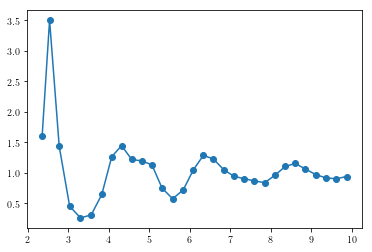

In [122]:


plt.plot(bin_edges,hist,'-o')
plt.show()

### Crltn (Unstructured points)

In [378]:
def CrltnFuncUnstruct(  coord_atoms_broken,
                        value,
                        CellVector, CellOrigin,
                        cutoff = 1.0,
                        NMAX = 1000, n_neigh_per_atom = 20,
                        WRAP = None, RADIAL = True,
                        dx = 1.0,
                    ):
############################################################
####### compute CrltnFunc for data defined over 
####### an unstructured grid point
############################################################    
#    pdb.set_trace()
    #--- zscore values
    value -= np.mean(value)
    value /= np.std(value)
    #--- dimensionless cords
    eta = GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin) 
    #---    
    nmax = min(NMAX, len( coord_atoms_broken ))
    i = 0
    nr = 0
    rlist = np.zeros(nmax*n_neigh_per_atom)
    rvect = np.zeros(nmax*n_neigh_per_atom*3).reshape((nmax*n_neigh_per_atom,3))
    flist = np.zeros(nmax*n_neigh_per_atom)
    while i < nmax: #--- pair-wise dist.
        #--- distance matrix
        df_dx = eta[ i+1:,0 ] - eta[ i, 0 ] #--- avoid double counting
        df_dy = eta[ i+1:,1 ] - eta[ i, 1 ]
        df_dz = eta[ i+1:,2 ] - eta[ i, 2 ]
        product = value[i+1:]*value[i]
        if WRAP: #--- pbc effects
            df_dx -= (df_dx > 0.5 )*1
            df_dx += (df_dx < - 0.5 )*1
            df_dy -= (df_dy > 0.5 )*1
            df_dy += (df_dy < - 0.5)*1
            df_dz -= (df_dz > 0.5)*1
            df_dz += (df_dz < - 0.5)*1
            
        #--- distance vector
        disp_vector = GetXYZ( CellVector, np.array([0.0,0.0,0.0]), np.c_[df_dx,df_dy,df_dz] ) 
        disp2 = disp_vector * disp_vector
        #--- distance
        df_sq = ( disp2[:,0]+disp2[:,1]+disp2[:,2] ) ** 0.5 
        #--- filtering
        disp_vector = disp_vector[ df_sq < cutoff ]
        product = product[ df_sq < cutoff ]
        df_sq = df_sq[ df_sq < cutoff ]    
        #--- concatenate
        assert nr+len(df_sq) <= rlist.shape[0], '%s, %s increase buffer size!'%(nr+len(df_sq),rlist.shape[0])
        rlist[nr:nr+len(df_sq)] = df_sq
        rvect[nr:nr+len(df_sq)] = disp_vector
        flist[nr:nr+len(df_sq)] = product.flatten()
        #---
        i += 1
        nr += len( df_sq )
        
    #--- histogram
    slist = rlist[rlist>0]
    rvect = rvect[rlist>0]
    flist = flist[rlist>0]
    rmin = slist.min()
    rmax = slist.max()

    if RADIAL:
        nbin = int((rmax-rmin)/dx)
        bins = np.linspace(rmin,rmax,nbin) #np.logspace(np.log10(rmin),np.log10(rmax),ndecades*4)
        fmean, bin_edges = np.histogram( slist, bins = bins, weights = flist ) #--- \sum f_i.fj
        rmean, bin_edges = np.histogram( slist, bins = bins, weights = slist ) #--- \sum r_i
        count, bin_edges = np.histogram( slist, bins = bins ) #--- n_i
        #
        rmean /= count #--- average distance: \sum r_i/n_i
        fmean /= count
        return rmean,  fmean, 1/count**0.5

    else: #--- 3d correlations
        xmin, xmax = rvect[:,0].min(), rvect[:,0].max()
        ymin, ymax = rvect[:,1].min(), rvect[:,1].max()
        zmin, zmax = rvect[:,2].min(), rvect[:,2].max()
        nbinx = int((xmax-xmin)/dx)
        nbiny = int((ymax-ymin)/dx)
        nbinz = int((zmax-zmin)/dx)
        bins_yxz = ( np.linspace( ymin, ymax, nbiny + 1, endpoint = True ), \
                     np.linspace( xmin, xmax, nbinx + 1, endpoint = True ), \
                     np.linspace( zmin, zmax, nbinz + 1, endpoint = True ) )

        #--- append negative r and corresponding f (c is hermitian)
        rvect = np.concatenate((rvect,-rvect),axis=0)
        flist = np.concatenate((flist,flist),axis=0)
        
        #--- swap columns
        rxcol = rvect[:,0]
        rycol = rvect[:,1]
        rzcol = rvect[:,2]
        rvect = np.c_[ rycol, rxcol, rzcol ]
        
        #--- histograms
        fmean, bin_edges = np.histogramdd( rvect, bins = bins_yxz, weights = flist ) #--- 3d histogram
        rx, bin_edges = np.histogramdd( rvect, bins = bins_yxz, weights = rxcol ) #--- \sum r_i
        ry, bin_edges = np.histogramdd( rvect, bins = bins_yxz, weights = rycol ) #--- \sum r_i
        rz, bin_edges = np.histogramdd( rvect, bins = bins_yxz, weights = rzcol ) #--- \sum r_i
        count, bin_edges = np.histogramdd( rvect, bins = bins_yxz ) #--- n_i
        
        
        #---- zero count????
        count[count==0] = 1
        rx /= count 
        ry /= count 
        rz /= count 
        fmean /= count
#        pdb.set_trace()

        
#        print (nbiny,nbinx,nbinz), fmean.shape, bin_edges[0].shape
        return rx, ry, rz,  fmean, 1/count**0.5



#--- test on random data
# n=1000*2
# xyz = np.random.random((n,3)) 
# xyz[:,1] *= 2.0
# val = np.random.random(n) #np.sin(2*np.pi*xyz[:,0])
# xv, yv, zv,  hist, err = CrltnFuncUnstruct(    xyz, 
#                                          val,
#                                          np.array([[1,0,0],[0,2,0],[0,0,1]]), np.array([0,0,0]),
#                                          WRAP = True, 
#                                          cutoff=1.0*3**.5, dx=0.05,
#                                          NMAX = n, n_neigh_per_atom = 10000,
#                                          RADIAL = None,
#                                          )


itime = 2000000
xv, yv, zv,  hist, err = CrltnFuncUnstruct(  np.c_[dfD2min[itime][['x','y','z']]], 
                                             np.c_[dfD2min[itime]['d2min']],
                                             CellVector[itime], CellOrigin[itime],
                                             WRAP = True, 
                                             cutoff = 15.0, #--- cutoff size to include neighbors
                                             dx = 2.25, #--- discretization length: 1st peak in rdf
                                             NMAX = 1000, #--- upper bounds for the number of atoms
                                             n_neigh_per_atom = 1000000, #--- neighbors
                                             RADIAL = None 
                                         )

#### Plot Crltns

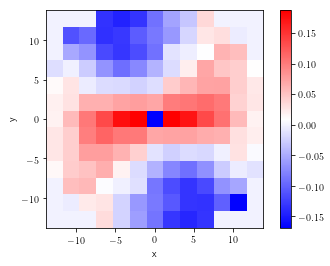

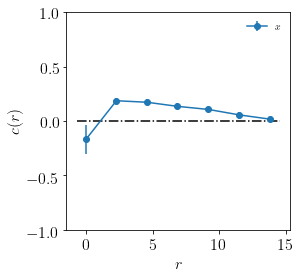

3.96508223080413e-18

In [379]:
def GetSlice2d( hist, err,
         (xv, yv, zv),
         xtol = 2.5,
         z = 0.0):
############################################################
####### Get a 2D slice out off a 3D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx,nz) = hist.shape
    indices = np.all([np.abs(zv-z)>0.0,np.abs(zv-z)<dx],axis=0) #--- filtering based on the given range
    #--- binning in xy
    flist = hist[indices]
    rvect = np.c_[yv[indices],xv[indices]]
    rx,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = xv[indices] ) #--- \sum r_i
    ry,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = yv[indices]) #--- \sum r_i
    error,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = err[indices] ) #--- \sum r_i
    fmean, bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = flist ) #--- 3d histogram
    count, bin_edges = np.histogramdd( rvect, bins = (ny, nx) ) #--- n_i

    count[count==0] = 1
    rx /= count 
    ry /= count 
    fmean /= count
    error /= count
    return rx, ry, fmean, error

def GetSlice1d( hist, err,
         (xv, yv),
         xtol = 2.5,
         **kwargs):
############################################################
####### Get a 1D slice out off a 2D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx) = hist.shape
    if 'y' in kwargs:
        y = kwargs['y']
        indices = np.all([np.abs(yv-y)>0.0,np.abs(yv-y)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = xv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = nx, weights = xv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = nx, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = nx ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = nx, weights = flist ) #--- 3d histogram
    elif 'x' in kwargs:
        x = kwargs['x']
        indices = np.all([np.abs(xv-x)>0.0,np.abs(xv-x)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = yv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = ny, weights = yv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = ny, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = ny ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = ny, weights = flist ) #--- 3d histogram
        
    #--- binning in xy

    count[count==0] = 1
    rdist /= count 
    fmean /= count
    error /= count
    return rdist, fmean, error


def Get_rc( xdata, ydata, cTOL ):
    try:
        xc1 = xdata[np.abs(ydata)<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc1d( crltn, err,
                 xv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                 ylim=(-1.0,+1.0),
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn.copy() #--- only xy plane
#    (m,n)=val.shape
    #--- along x 
    xv2 = xv.copy()
    dx = xv2[1] - xv2[0]
    #
    xdata = xv2 #np.arange(0,(n/2+n%2)) * dx
    ydata = val #[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.errorbar( xdata, ydata,yerr = err, fmt='-o',label=r'$x$')       
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
        #
#        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return xc
    
    
    
    
    
#--- get 2d slice
xv2d, yv2d, hist2d, err2d = GetSlice2d( hist, err,
                                       (xv, yv, zv),
                                       z=0.0, xtol = 2.25
                                      )
#--- bitmap
PltBitmap(hist2d, 
          xlabel = 'x', ylabel = 'y',
          xlim=(xv2d.min(),xv2d.max()),ylim=(yv2d.min(),yv2d.max()),
          zscore = None,
          frac = 1.0, #--- plot a patch
          ) 

#--- get 1d slice
xv1d, hist1d, err1d =   GetSlice1d( hist2d, err2d,
                             (xv2d, yv2d),
                             xtol = 2.25,
                             y=0.0)   
#--- plot
PltCrltnFunc1d( hist1d[xv1d>0.0], err1d[xv1d>0.0],
                 xv1d[xv1d>0.0],
                 fileName = 'cr.%s.png'%itime,
#                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )

### grid for interpolation

In [387]:
#--- mean dist between atoms 
natoms = len( coord_atoms_broken[ 0 ] ) 
CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ 0 ] )
volume = np.linalg.det( CellVectorOrtho )
dmean = ( volume / natoms ) ** (1.0/3.0) 

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = GetCubicGrid( CellOrigin[ 0 ], 
                                                 CellVector[ 0 ], 
                                                 dmean,
                                                 margin = 0.0 * dmean )
xi = np.array(zip(xv.flatten(), yv.flatten(), zv.flatten()))


#--- interpolate

#--- add replicas
GetCopies( dfD2min,
           CellVector,
           CellOrigin,
           KEYS = dfD2min.keys(),
           ev = 0.3, #--- don't change this! need a full copy to compute displ.
           columns_r = ['x','y','z'],
           columns_rm = ['xm','ym','zm'] #--- transform these two sets of columns
         )



# dfD2min_intrp = {}
# times = dfD2min.keys()
# times.sort()
# for time_i in times:
#     print time_i
#     df_i = dfD2min[ time_i ]
    
#     #--- add copies
#     df = df_i
#     xyz = np.c_[df[['x','y','z']].astype('float')]
#     xyz_copy = AddCopies( xyz, CellVector[ time_i ],
#                           id=df_i['id'],
#                           type = df_i['type'],
#                           d2min = df_i['d2min'],
#                         )
# #    pdb.set_trace()
#     dfD2min[time_i] = xyz_copy.copy()

    
#    df_i = dfD2min[ time_i ]

    #--- get points from which values are interpolated
#     pointsValues =  GetPoints( CellOrigin[ time_i ], 
#                                CellVector[ time_i ],
#                                np.c_[df_i[['x','y','z']]].astype('float'), #--- give mapped coordinates
#                                ev = 0.0,
#                                output_attr = ['x','y','z'],
# #                                id = df_i['id'],
# #                                type = df_i['type'],
#                                x = df_i['x'],
#                                y = df_i['y'],
#                                z = df_i['z'],
#                                d2min = df_i['d2min'],

#                              )
        
    #--- interpolate
#     points = df_i[['x','y','z']]
#     values = df_i[['d2min']]
#     grid_z = scp_int.griddata(points, values, xi, method='linear')#,fill_value=0.0)
#     assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'
    
#     #--- store in dataframe
#     dfD2min_intrp[ time_i ] = pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min'])


TypeError: AddCopies() takes exactly 2 arguments (6 given)

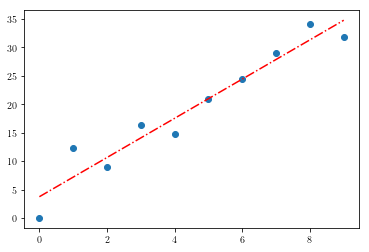

In [579]:


x=np.arange(10)
y=3.1*x + np.random.random(10)*10
z=np.polyfit(x,y,1)

plt.plot(x,y,'o')
plt.plot(x,func(x,z[0],z[1]),'-.r')

plt.show()

## Gradients

### Interpolate Displacements
#### cubic grid

In [621]:
def GetCubicGrid( CellOrigin, CellVector, dmean, margin  ):

    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    
    volume = np.linalg.det( CellVectorOrtho )


    [nx, ny, nz] = map( int, (np.array(VectorNorm)+2*margin) / dmean )
    if nx%2 == 0:
        nx += 1
    if ny%2 == 0:
        ny += 1
    if nz%2 == 0:
        nz += 1
    
    x = np.linspace( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin, nx,endpoint=False)
    y = np.linspace( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin, ny,endpoint=False)
    z = np.linspace( CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin, nz,endpoint=False)

    return (x, y, z), np.meshgrid(x, y,z)



#--- mean dist between atoms 
natoms = len( coord_atoms_broken[ 0 ] ) 
CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ 0 ] )
volume = np.linalg.det( CellVectorOrtho )
dmean = ( volume / natoms ) ** (1.0/3.0) 

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = GetCubicGrid( CellOrigin[ 0 ], 
                                                 CellVector[ 0 ], 
                                                 dmean,
                                                 margin = 0.0 * dmean )
xi = np.array(zip(xv.flatten(), yv.flatten(), zv.flatten()))


#### center box + margin

In [623]:
df_intrp = {}
times = coord.keys()
times.sort()
for time_i, time_j in zip(times[:-1], times[1:]):  
    print time_i
    if REF == 'initial':
        time_i = 0
    #--- get a chunck of full copies
    df_i = coord[ time_i ]
    df_j = coord[ time_j ]
    
    #--- get points from which values are interpolated
    pointsValues =  GetPoints( CellOrigin[ time_i ], 
                               CellVector[ time_i ],
                               np.c_[df_i[['xm','ym','zm']]].astype('float'), #--- give mapped coordinates
                               ev = 0.3,
                               output_attr = ['xm','ym','zm'],
                               id = df_i['id'],
                               type = df_i['type'],
                               x = df_i['x'],
                               y = df_i['y'],
                               z = df_i['z'],
                               ux = df_j['ux'],
                               uy = df_j['uy'],
                               uz = df_j['uz'],
                             )
        
    #--- interpolate
    points = pointsValues[['xm','ym','zm']]
    values = pointsValues[['ux','uy','uz']]
    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'
    
    #--- store in dataframe
    df_intrp[ time_j ] = pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','ux','uy','uz'])


0
500000
1000000
1500000


#### Print

In [69]:
file_name = 'intrp.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass

for itime in df_intrp:
    PrintOvito( df_intrp[ itime ], 
                    open( file_name,'a'), 
                    footer = 'ITIME=%s'%itime,
                    attr_list=['x','y','z','ux','uy','uz'] )


### Strain tensor

In [486]:
def GetDerivX( value, lx ):
    (ny,nx,nz) = value.shape

    dvalx = np.zeros(ny*nx*nz).reshape((ny,nx,nz))
    valq = np.fft.fftn( value )
    for i in xrange(-(ny/2),ny/2+ny%2):
        for j in xrange(-(nx/2),nx/2+nx%2):
            for k in xrange(-(nz/2),nz/2+nz%2):
                dvalx[i,j,k] = 1j*(2*pi*j/lx)*valq[i,j,k]
    return np.fft.ifftn(dvalx).real

def GetDerivY( value, ly ):
    (ny,nx,nz) = value.shape

    dvalx = np.zeros(ny*nx*nz).reshape((ny,nx,nz))
    valq = np.fft.fftn( value )
    for i in xrange(-(ny/2),ny/2+ny%2):
        for j in xrange(-(nx/2),nx/2+nx%2):
            for k in xrange(-(nz/2),nz/2+nz%2):
                dvalx[i,j,k] = 1j*(2*pi*i/ly)*valq[i,j,k]
    return np.fft.ifftn(dvalx).real

def GetDerivZ( value, lz ):
    (ny,nx,nz) = value.shape

    dvalx = np.zeros(ny*nx*nz).reshape((ny,nx,nz))
    valq = np.fft.fftn( value )
    for i in xrange(-(ny/2),ny/2+ny%2):
        for j in xrange(-(nx/2),nx/2+nx%2):
            for k in xrange(-(nz/2),nz/2+nz%2):
                dvalx[i,j,k] = 1j*(2*pi*k/lz)*valq[i,j,k]
    return np.fft.ifftn(dvalx).real


def GetStrain( value, (xlin,ylin,zlin), (xv,yv,zv), method='gradient'):
    #--- reshape matrix
    nx,ny,nz = len(xlin), len(ylin),len(zlin)
    lx = xlin[-1]-xlin[0]
    ly = ylin[-1]-ylin[0]
    lz = zlin[-1]-zlin[0]
    ux = np.c_[value['ux']].reshape((ny,nx,nz))
    uy = np.c_[value['uy']].reshape((ny,nx,nz))
    uz = np.c_[value['uz']].reshape((ny,nx,nz))

    
    #--- gradient
    if method == 'diff':
        appendd=ux[:,0,:].reshape((ny,1,nz))
        ux_x = np.diff(ux, axis=1,append=appendd)
        appendd=ux[0,:,:].reshape((1,nx,nz))
        ux_y = np.diff(ux, axis=0,append=appendd)
        appendd=ux[:,:,0].reshape((ny,nx,1))
        ux_z = np.diff(ux, axis=2,append=appendd)

        appendd=uy[:,0,:].reshape((ny,1,nz))
        uy_x = np.diff(uy, axis=1,append=appendd)
        appendd=uy[0,:,:].reshape((1,nx,nz))
        uy_y = np.diff(uy, axis=0,append=appendd)
        appendd=uy[:,:,0].reshape((ny,nx,1))
        uy_z = np.diff(uy, axis=2,append=appendd)

        appendd=uz[:,0,:].reshape((ny,1,nz))
        uz_x = np.diff(uz, axis=1,append=appendd)
        appendd=uz[0,:,:].reshape((1,nx,nz))
        uz_y = np.diff(uz, axis=0,append=appendd)
        appendd=uz[:,:,0].reshape((ny,nx,1))
        uz_z = np.diff(uz, axis=2,append=appendd)

    if method == 'fft':
        ux_x = GetDerivX( ux,lx ) 
        ux_y = GetDerivY( ux,lx ) 
        ux_z = GetDerivZ( ux,lx ) 

        uy_x = GetDerivX( uy,ly ) 
        uy_y = GetDerivY( uy,ly ) 
        uy_z = GetDerivZ( uy,ly ) 

        uz_x = GetDerivX( uz,lz ) 
        uz_y = GetDerivY( uz,lz ) 
        uz_z = GetDerivZ( uz,lz ) 

    if method == 'gradient':
        ux_x = np.gradient(ux,xlin,axis=1,edge_order=2)
        ux_y = np.gradient(ux,ylin,axis=0,edge_order=2)
        ux_z = np.gradient(ux,zlin,axis=2,edge_order=2)
        #
        uy_x = np.gradient(uy,xlin,axis=1,edge_order=2)
        uy_y = np.gradient(uy,ylin,axis=0,edge_order=2)
        uy_z = np.gradient(uy,zlin,axis=2,edge_order=2)
        #
        uz_x = np.gradient(uz,xlin,axis=1,edge_order=2)
        uz_y = np.gradient(uz,ylin,axis=0,edge_order=2)
        uz_z = np.gradient(uz,zlin,axis=2,edge_order=2)

    #--- strain
    exx = ux_x
    exy = 0.5 * ( ux_y + uy_x )
    exz = 0.5 * ( ux_z + uz_x )

    eyx = exy
    eyy = uy_y
    eyz = 0.5 * ( uy_z + uz_y )

    ezx = exz
    ezy = eyz
    ezz = uz_z
    
    #--- subtract mean
    exx -= np.mean(exx)
    exy -= np.mean(exy)
    exz -= np.mean(exz)

    eyx -= np.mean(eyx)
    eyy -= np.mean(eyy)
    eyz -= np.mean(eyz)

    ezx -= np.mean(ezx)
    ezy -= np.mean(ezy)
    ezz -= np.mean(ezz)
    
    return pd.DataFrame(np.c_[xv.flatten(),yv.flatten(),zv.flatten(),
                 exx.flatten(), eyy.flatten(), ezz.flatten(), 
                 exy.flatten(), eyz.flatten(), ezx.flatten()], 
                 columns = ['x','y','z','exx','eyy','ezz','exy','eyz','ezx'])



Strain = {}
for itime in df_intrp:
    Strain[itime] = GetStrain(df_intrp[ itime ], 
                              (xlin,ylin,zlin), (xv,yv,zv),
                              method = 'gradient')


#### imshow

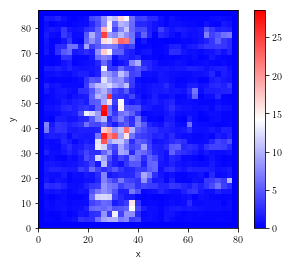

In [37]:
def FilterMatrix( CellVector, CellOrigin,
                  (xlin, ylin, zlin),
                  (xv, yv, zv ),
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>=xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>=ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>=zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>=xlo,xv<xhi, yv>=ylo,yv<yhi, zv>=zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[ a[i,j] for j in xrange(-(ngrid/2),ngrid/2+ngrid%2)] 
                              for i in xrange(-(mgrid/2),mgrid/2+mgrid%2)])

def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
#    plt.xlim(center[0]-(ngrid/2)*frac,center[0]+(ngrid/2)*frac)
#    plt.ylim(center[1]-(mgrid/2)*frac,center[1]+(mgrid/2)*frac)
#    plt.xlim(xlim[0]*frac,xlim[1]*frac)
#    plt.ylim(ylim[0]*frac,ylim[1]*frac)
    plt.colorbar( pos, fraction = 0.04)
    plt.savefig('cxy.png',dpi=75,bbox_inches='tight')
    plt.show()


    

itime = np.max(dfD2min_intrp.keys())
#--- reshape value
nx,ny,nz = len(xlin), len(ylin),len(zlin) 
#value = np.c_[Strain[itime]['exy']].reshape(((ny,nx,nz)))
value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))

# lx=xlin[-1]-xlin[0]
# ly=ylin[-1]-ylin[0]
# #value = np.sin(2*pi*np.c_[(df_intrp[itime]['x']-xlin[0])]/lx)
# value = np.c_[df_intrp[itime]['ux']]
# value = value.reshape(((ny,nx,nz)))
#print value.shape

#--- filter value
# value = FilterMatrix( CellVector[0], CellOrigin[0],
#                   (xlin, ylin, zlin),
#                   (xv, yv, zv ),
#                    value )
#print value.shape
#print vf.shape

CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
#--- xy plane
#val = value[:,:,-1].copy()
val = value[:,:,nz/2].copy()
#print val.shape

PltBitmap(val, 
          xlabel = 'x', ylabel = 'y',
          xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
          zscore = None,
          frac = 1.0, #--- plot a patch
        )

In [36]:
dfD2min_intrp[itime]['d2min'].max()

56.80991402637505

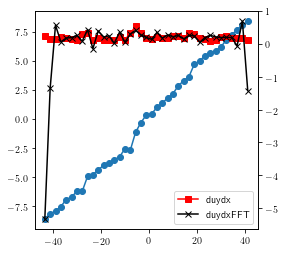

In [475]:
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(111)
ax2=ax.twinx()

# ax.set_xlim(min(xlin),max(xlin))
# ax2.set_xlim(min(xlin),max(xlin))
# ax.set_ylim(-1,1)
# ax2.set_ylim(-1,1)

f = val[:,0]
df=val0[:,0]

dx=xlin[1]-xlin[0]
ax.plot(ylin, f,'-o',label='uy')
#ax2.plot(ylin, np.gradient(f,xlin,edge_order=2)/(2*pi/lx),'-s',color='red',label='duydx')
ax2.plot(ylin, np.gradient(f,ylin,edge_order=2),'-s',color='red',label='duydx')
#ax2.plot(xlin[:-1], np.diff(f)/dx/(2*pi/lx),'-s',color='red',label='duydx')
#ax2.plot(ylin,df/(2*pi/lx),'-x',color='black',label='duydxFFT')
ax2.plot(ylin,df,'-x',color='black',label='duydxFFT')


ax2.legend()
plt.show()

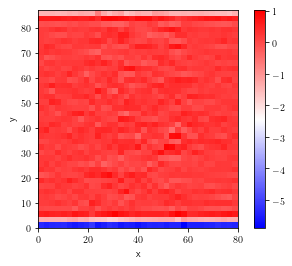

In [471]:
itime = np.max(Strain.keys())
nx,ny,nz = len(xlin), len(ylin),len(zlin) 

# value = np.sin(2*pi*np.c_[df_intrp[itime]['x']]/nx)
# value = value.reshape(((ny,nx,nz)))
#dvalux = GetDerivX( value,lx )

#value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))
dvaluy = GetDerivY( value,ly )

exy=dvaluy
#--- xy plane
value0 = exy[:,:,-1].copy()

PltBitmap(value0, 
          xlabel = 'x', ylabel = 'y',
          xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
          zscore = None,
          frac = 1.0, #--- plot a patch
        )

In [472]:
val0=exy[:,:,-1].copy()

#### Print

In [73]:
file_name = 'strain.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass
    
times = Strain.keys()
times.sort()
for itime in times:
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1

    
    PrintOvito( Strain[ itime ], 
                    open( file_name,'a'), 
                    footer = 'epsilon=%2.1e'%(2*ebulk),
                    attr_list=['x','y','z','exx','eyy','ezz','exy','eyz','ezx'] )
    

#### Auto-Correlations

In [38]:
def GetAutoCorrelation( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny, nz ) =  value.shape
    n = nx * ny * nz
    vq = np.fft.fftn(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
    return v_real


Crltn = {}
for itime in dfD2min_intrp:
    #
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
#    value = np.c_[Strain[itime]['exy']].reshape(((ny,nx,nz)))
    value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))
#    value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))
    #--- shuffle
#     ( nx, ny, nz ) =  value.shape
#     slist = value.flatten()
#     np.random.shuffle(slist)
#     value=slist.reshape((nx, ny, nz))    
    #
    #--- filter value
#     value = FilterMatrix( CellVector[0], CellOrigin[0],
#                   (xlin, ylin, zlin),
#                   (xv, yv, zv ),
#                    value )

    Crltn[ itime ] = GetAutoCorrelation( value )


#### Print

itime= 500000


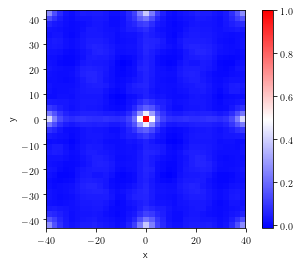

itime= 1000000


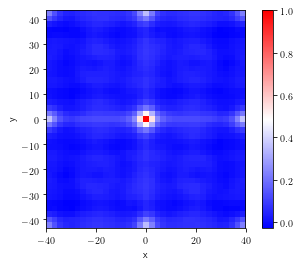

itime= 2000000


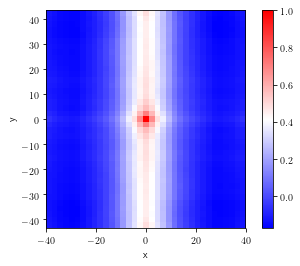

itime= 1500000


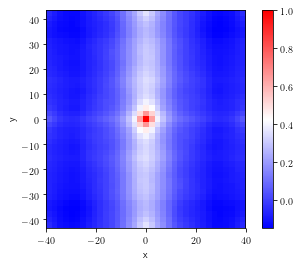

In [39]:

def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
        
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1])) #,vmin=-.01, vmax=.01)
    plt.xlim(xlim[0]*frac,xlim[1]*frac)
    plt.ylim(ylim[0]*frac,ylim[1]*frac)

    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()


for itime in Crltn:
    print 'itime=',itime
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
    #    
    crltn = Crltn[ itime ]
    #--- xy plane
    val = crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 1, #--- plot a patch
              zscore = False,
              fileName = 'cxy.%s.png'%itime,
              dpi = 60
            )
    # #--- zx plane
    # val = crltn[0,:,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'x',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )
    # #--- zy plane
    # val = crltn[:,0,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'y',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )



#### Crltn Length

itime= 500000


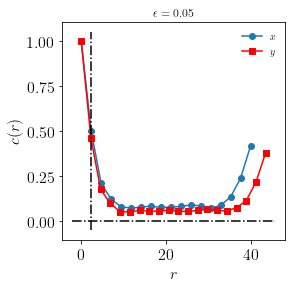

itime= 1000000


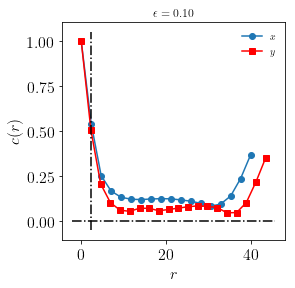

itime= 2000000


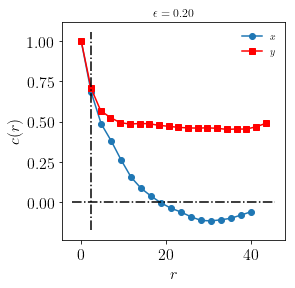

itime= 1500000


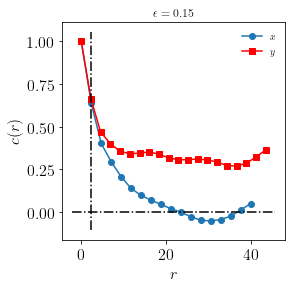

In [40]:
def Get_rc( xdata, ydata, cTOL ):
    try:
        xc1 = xdata[np.abs(ydata)<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 (xv,yv),
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    xdata = np.arange(0,(n/2+n%2)) * dx
    ydata = val[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-o',label=r'$x$')       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    xdata = np.arange(0,(m/2+m%2)) * dy
    ydata = val[0:(m/2+m%2),0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-s', color = 'red',label=r'$y$')
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
#        ax.plot((rc,rc),ax.axis()[2:],'-.r')
        #
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return (xc, yc)
    
    

for itime in Crltn:
    print 'itime=',itime
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1
    #---
    PltCrltnFunc( Crltn[ itime ], 
                 (xv,yv),
                 fileName = 'cr.%s.png'%itime,
                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )

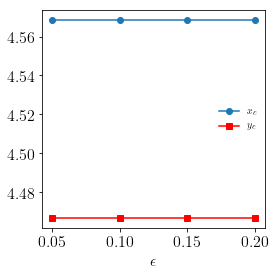

In [77]:
#--- extract length
ebulk = []
Xc = []
Yc = []
keys = Crltn.keys()
keys.sort()
for itime in keys:
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk += [0.5*dx/l1]
    
    xc, yc = PltCrltnFunc( Crltn[ itime ], 
                          (xv,yv),
                          cTOL = 4e-2,
                          PLOT = None,
                         )
    Xc += [xc]
    Yc += [yc]

#--- plot
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
xstr = r'$\epsilon$'
ystr = r'$r_c$'
ax.set_xlabel(xstr,fontsize=16)
#ax.set_ylabel(ystr,fontsize=16)
ax.tick_params(labelsize=16)
#
ax.plot( 2*np.array(ebulk), Xc,'-o', color='C0', label = r'$x_c$')
ax.plot( 2*np.array(ebulk), Yc,'-s', color='red', label = r'$y_c$')
ax.legend(frameon=False)
plt.savefig('rc.png',dpi=75,bbox_inches='tight')
plt.show()
